In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
%%capture
!pip install transformers==4.19.2
!pip install rouge_score


In [4]:
from datasets import load_metric
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/wikiHow.csv')
df.head()

,title,heading,paragraph
0,3 Ways to Finish and Protect Diamond Art,Confirm that all of the diamonds are in the ri...,"Onceyousealthepainting,youwontbeabletomoveanyo..."
1,3 Ways to Finish and Protect Diamond Art,Press all of the diamonds down with a roller.,"Ifthediamondsarentallcompletelyflat,youllgetan..."
2,3 Ways to Finish and Protect Diamond Art,Pick any hair or lint off the painting.,"Ifanyhairorlintgetsstuckunderthesealer,itcould..."
3,3 Ways to Finish and Protect Diamond Art,Wipe the painting with a cloth or toothbrush t...,Begentleandwipetheentirepainting.Thisshouldget...
4,3 Ways to Finish and Protect Diamond Art,Choose a waterproof paint sealer to protect th...,Youhaveafewchoicesforthetypeofsealertouse.Anyt...


to deal with the data duplicates

In [5]:
print(df.shape)
df=df.dropna()
print(df.shape)

(40673, 3)
(40108, 3)


In [6]:
print(df.shape)
df=df.drop_duplicates()
print(df.shape)

(40108, 3)
(34725, 3)


to deal with data outliers (data length is too low or too high)

In [7]:
df['length']=df.paragraph.map(lambda x: len(x.split(" ")))

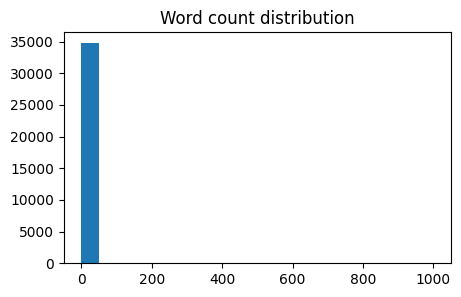

In [8]:
numofwords=df.length
from matplotlib import pyplot as plt

fig = plt.figure(figsize =(5, 3))
plt.hist(numofwords.to_numpy(),bins =[0,50,100,200,300,500,1000])
plt.title("Word count distribution")
plt.show()

In [9]:
# remove the outliers

tempDf=df[df.length<=200]
print(tempDf.shape)

(34725, 4)


In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [11]:
max_input_length = 1024
max_output_length = 64
Batch_size = 16

def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["paragraph"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["heading"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [1 for _ in range(len(batch["input_ids"][0]))]
    ]
    batch["global_attention_mask"][0][0]=1
    batch["labels"] = outputs.input_ids

    batch["labels"] = [
       [-100 if token == tokenizer.pad_token_id else token for token in labels]
       for labels in batch["labels"]
    ]
    return batch

In [12]:
import numpy as np
train, validate,test = np.split(tempDf.sample(frac=1, random_state=42), [int(.6*len(tempDf)), int(.8*len(tempDf))])
print(train.shape)
print(validate.shape)
print(test.shape)

(20835, 4)
(6945, 4)
(6945, 4)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [13]:
validate = validate[:20]

In [14]:
validate.shape

(20, 4)

In [15]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
validate_dataset = Dataset.from_pandas(validate)


In [16]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=Batch_size,
    remove_columns=["title","heading","paragraph","length","__index_level_0__"],
)


Map:   0%|          | 0/20835 [00:00<?, ? examples/s]

In [17]:
val_dataset = validate_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=Batch_size,
    remove_columns=["title","heading","paragraph","length","__index_level_0__"],
)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [18]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

In [19]:
from transformers import AutoModelForSeq2SeqLM
led=AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384",gradient_checkpointing=True)
led.config.num_beams=2
led.config.max_length=64
led.config.min_length=2
led.config.length_penalty=2.0
led.config.no_repeat_ngram_size=3
led.config.early_stopping=True
rouge =load_metric("rouge")


def compute_metrics(pred):
    labels_ids=pred.label_ids
    pred_ids=pred.predictions

    pred_str=tokenizer.batch_decode(pred_ids,skip_special_tokens=True)
    labels_ids[labels_ids==-100]=tokenizer.pad_token_id
    label_str=tokenizer.batch_decode(labels_ids,skip_special_tokens=True)

    rouge_output=rouge.compute(predictions=pred_str,references=label_str,rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import transformers
transformers.logging.set_verbosity_error()

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=Batch_size,
    per_device_eval_batch_size=Batch_size,

    output_dir="./",
    logging_steps=5,
    save_steps=10,
    eval_steps=10,
    save_total_limit=2,

    gradient_accumulation_steps=4,
    num_train_epochs=10
)

Downloading:   0%|          | 0.00/618M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:392: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [20]:
trainer=Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [21]:
import pandas as pd
sample_paragraph ="the reason why i loved the top down culture at apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +!0 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to kook up to to help guide decisins is time-saving, it helps us focus on the desing craft instead of project management"
data=[sample_paragraph]
df=pd.DataFrame(data,columns=['paragraph'])
df['paragraph'][0]

from datasets import Dataset
df_test = Dataset.from_pandas(df)

df_test

Dataset({
    features: ['paragraph'],
    num_rows: 1
})

In [ ]:
from datasets import load_metric
import torch

from datasets import load_dataset, load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = LEDTokenizer.from_pretrained("/content/checkpoint-60")
model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-70").to(device).half()
def generate_answer(batch):
    inputs_dict = tokenizer(
        batch["paragraph"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )
    input_ids = inputs_dict.input_ids.to(device)
    attention_mask = inputs_dict.attention_mask.to(device)
    global_attention_mask = torch.zeros_like(attention_mask)

    predicated_abstract_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        global_attention_mask=global_attention_mask)
    batch["generated_heading"] = tokenizer.batch_decode(
        predicated_abstract_ids, skip_special_tokens=True
    )
    return batch

result =df_test.map(generate_answer, batched=True, batch_size=2)




In [55]:
result["generated_heading"]

['Have a leader who can help you with your decisions.']

In [2]:
!pip install keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 11.4 MB/s eta 0:00:00


In [5]:
from keybert import KeyBERT

# Initialize the KeyBERT model
kw_model = KeyBERT()

# Function to extract keywords
def extract_keywords(text):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=5)
    return [keyword[0] for keyword in keywords]

# Example usage
sample_paragraph ="the reason why i loved the top down culture at apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +!0 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to kook up to to help guide decisins is time-saving, it helps us focus on the desing craft instead of project management"

keywords = extract_keywords(sample_paragraph)
print(f"Keywords: {keywords}")


Keywords: ['culture apple', 'guide decisins', 'apple important', 'culture spend', 'culture']


In [ ]:
def generate_summary(text):
    input_ids = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(input_ids, max_length=60, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

sample_paragraph ="the reason why i loved the top down culture at apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +!0 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to kook up to to help guide decisins is time-saving, it helps us focus on the desing craft instead of project management"

summary = generate_summary(sample_paragraph)
print(f"Summary: {summary}")
